In [1]:
from IPython.core.display import display, HTML
display(HTML("""
    <style>
    .container { width:70% !important; }
    .output_png {display: table-cell; text-align: left; vertical-align: middle;margin:auto;}
    </style>
    """))
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%autosave 120

import utils as utils
import datasets as dts
import tensorflow as tf
import matplotlib.pyplot as plt

tf.enable_eager_execution()  # make sure tf is in eager mode

TONE_SIGMA = 0.1  # tone curve jitter: if set to None --> no color jitter
SS_SIGMA = 0.5  # probability to apply ss approximation: 1 --> not apply; 0 --> always apply

Autosaving every 120 seconds


<span style="font-family:sans-serif;color:blue;font-size:1.2em;"> Many of the functions involve stochastic operations, if you encounter an error, it's probabaly some of the constraints are violated (e.g. out of bound). During training these samples will be automatically dropped. Here, you can re-run that section a few times (usually one more time would fix the error).</span>

In [2]:
# util function for image conversion and display
def display_img(ts_img, is_norm=False):
  ts_img = tf.squeeze(ts_img)
  if is_norm:
    ts_img = (ts_img + 1)/2
  return tf.image.convert_image_dtype(
      utils.rgb_to_srgb(ts_img),
      dtype=tf.uint8,
      saturate=True).numpy()

### Image source preparation

In [3]:
image_path = '/home/zhangxer77/code/cezhang/portraitshadow/input/008.png'
segmentation_path = '/home/zhangxer77/code/cezhang/portraitshadow/input_mask_ind/008_0.png'
bbox_path = '/home/zhangxer77/code/cezhang/portraitshadow/input_mask_ind/008.txt'
silhouette_path = '/home/zhangxer77/code/cezhang/portraitshadow/silhouette/1349034.png'
bbox = dts.read_bbox(bbox_path)[0]

### Data I/O

In [4]:
data_dict = {}
data_dict['image_path'] = image_path
data_dict['silhouette_path'] = silhouette_path
data_dict['bbox'] = bbox
data_dict['shadowed_before'] = utils.read_float(image_path, channel=3, itype='jpg', is_linear=True)
data_dict['segmentation'] = utils.read_float(segmentation_path, channel=1, itype='png', is_linear=False)
data_dict['silhouette'] = utils.read_float(silhouette_path, channel=1, itype='png', is_linear=False)

In [6]:
rsz_ratio = 1.0
size = (256, 256)
image_concat = tf.concat([data_dict['shadowed_before'], data_dict['segmentation']], axis=2)
processed_images = dts.align_images_and_segmentation(
    image_concat, size=size, bbox=bbox, rsz=rsz_ratio, param_save=False, is_train=True)
shadow_lit_image = processed_images[..., :3]
segmentation = processed_images[..., -1:]

In [7]:
shadow_occl_image = shadow_lit_image
curve_gain = 0.5 + tf.random.uniform([3], -TONE_SIGMA, TONE_SIGMA, tf.float32)
shadow_occl_image_tone = utils.apply_tone_curve(shadow_occl_image, gain=curve_gain, is_rgb=True)
color_matrix = utils.get_ctm_ls(shadow_occl_image, shadow_occl_image_tone)
shadow_occl_image = utils.apply_ctm(shadow_occl_image, color_matrix)

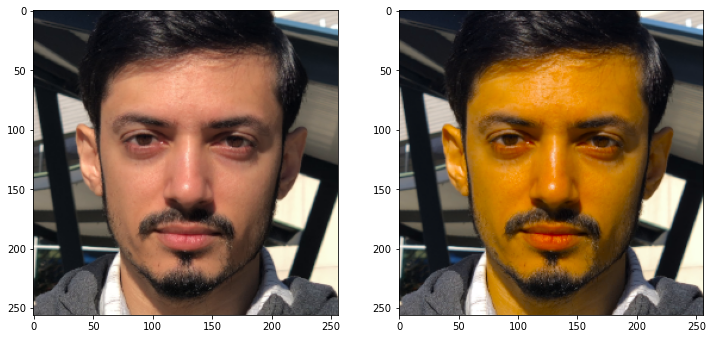

In [8]:
# Input image before and after applied color jitter
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(display_img(shadow_lit_image))
plt.subplot(1,2,2)
plt.imshow(display_img(shadow_occl_image))
plt.show()


### Generate shadow mask from 1) perlin and 2) silhouette image
<b>Spatially-varying blur is applied</b>

In [14]:
shadow_mask_hard = 1 - data_dict['silhouette']
shadow_mask_hard_perlin = utils.render_perlin_mask(size=size)
shadow_mask_hard_silh = utils.render_silhouette_mask(
    silhouette=shadow_mask_hard,
    size=size,
    segmentation=segmentation)

In [19]:
shadow_mask_hard = shadow_mask_hard_perlin
shadow_mask_hard_inv = 1 - shadow_mask_hard

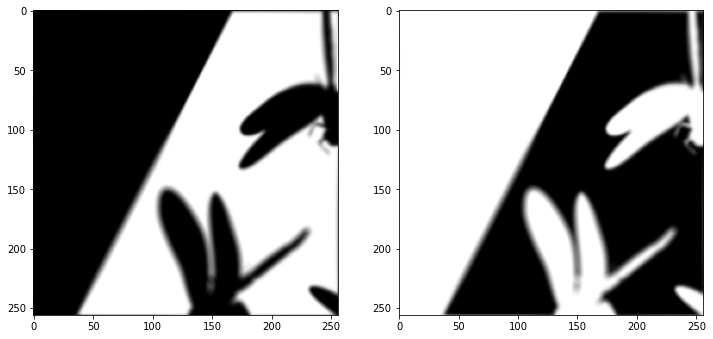

In [15]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(shadow_mask_hard_silh[..., 0].numpy(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow((1-shadow_mask_hard_silh[..., 0]).numpy(), cmap='gray')
plt.show()

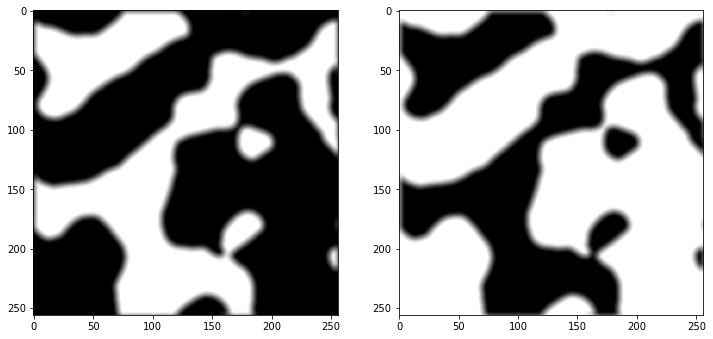

In [16]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(shadow_mask_hard_perlin[..., 0].numpy(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow((1-shadow_mask_hard_perlin[..., 0]).numpy(), cmap='gray')
plt.show()

### Apply subsurface scattering image-space approximation
<b>Apply half of the time (random)</b>

In [20]:
prob_apply_ss = tf.random.uniform([])
shadow_mask_ss = tf.cond(
  tf.greater(prob_apply_ss, tf.constant(SS_SIGMA)),
  lambda: utils.apply_ss_shadow_map(
      shadow_mask_hard),
  lambda: tf.image.grayscale_to_rgb(shadow_mask_hard))
shadow_mask_ss_inv = 1 - shadow_mask_ss

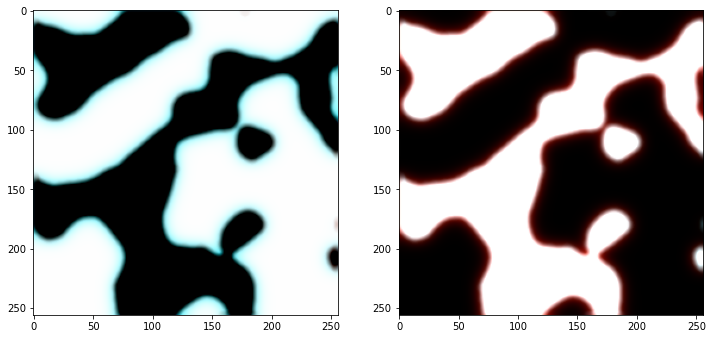

In [21]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(shadow_mask_ss_inv.numpy())
plt.subplot(1,2,2)
plt.imshow(shadow_mask_ss.numpy())
plt.show()

### Apply per-pixel intensity spatially-varying scaling

In [22]:
# Apply intensity variation
intensity_mask = utils.get_brightness_mask(size=size, min_val=0.4)
shadow_mask_sv = shadow_mask_ss_inv * tf.expand_dims(intensity_mask, 2)
# shadow_mask_hard_inv = tf.image.grayscale_to_rgb(shadow_mask_hard_inv)

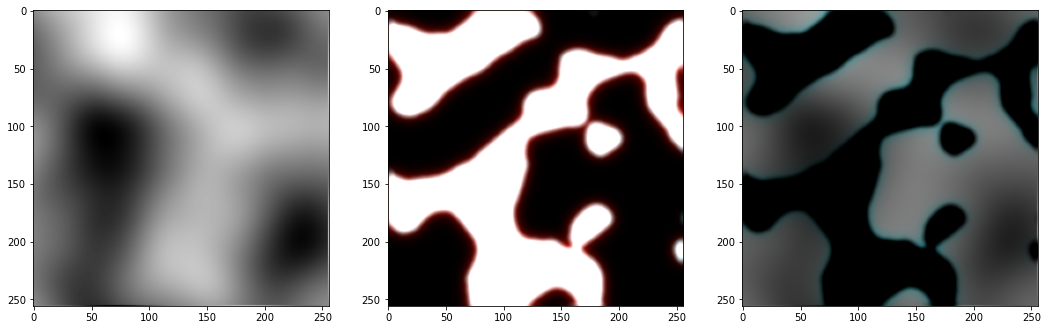

In [23]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(intensity_mask.numpy(), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(shadow_mask_ss.numpy())
plt.subplot(1,3,3)
plt.imshow(shadow_mask_sv.numpy())
plt.show()

### Linear blend the lit and shadow images

In [24]:
# Apply shadow mask to image
shadow_hard_image = shadow_mask_sv * shadow_occl_image + shadow_mask_ss * shadow_lit_image
input_shadow = shadow_hard_image * segmentation

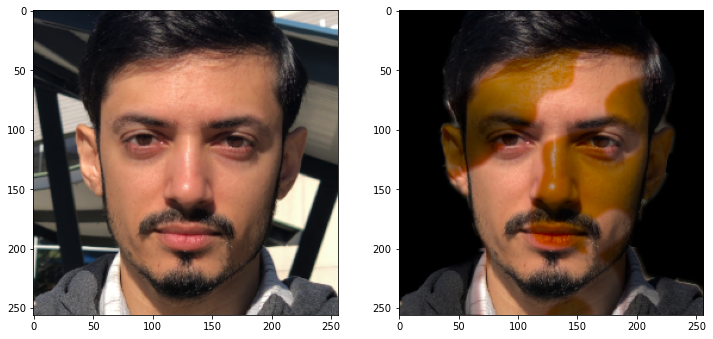

In [25]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(display_img(shadow_lit_image))
plt.subplot(1,2,2)
plt.imshow(display_img(input_shadow))
plt.show()


## Interactive visualization of a few parameters

### wavelength-dependent filtering, visualizing how the radius changes subsurface scattering approximation

In [26]:
def wv_filter(radius):
    shadow_map = utils.wavelength_filter(shadow_mask_hard_perlin, num_lv=6, scale=radius, is_rgb=False)
    shadow_map_perlin = tf.minimum(1., shadow_map/0.6)  # a heuristic scalar for more stable normalization
    shadow_map = utils.wavelength_filter(shadow_mask_hard_silh, num_lv=6, scale=radius, is_rgb=False)
    shadow_map_perlin = tf.minimum(1., shadow_map/0.6)  # a heuristic scalar for more stable normalization
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(display_img(shadow_map_perlin))
    plt.subplot(1,2,2)
    plt.imshow(display_img(shadow_map))
    plt.show()

In [50]:
interact(wv_filter, radius=(1,6,1))

interactive(children=(IntSlider(value=3, description='radius', max=6, min=1), Output()), _dom_classes=('widget…

<function __main__.wv_f(radius)>

### spatially-varying with perlin noise, visualizing how the persistence and threshold change the intensity mask

In [27]:
def sv_mask(threshold, max_persistence):
    perlin_map = utils.perlin_collection(
        size=(size[0], size[1]),
        reso=[2, 2],
        octaves=2,
        persistence=tf.random.uniform([], 0.05, max_persistence))
    perlin_map = perlin_map / (1. / (threshold + 1e-6)) + threshold
    perlin_map = tf.minimum(perlin_map, 1.)
    
    plt.figure(figsize=(12,6))
    plt.imshow(display_img(perlin_map), cmap='gray')
    plt.show()

In [67]:
interact(sv_mask, threshold=(0.1, 0.8, .1), max_persistence=(0.05, 0.8, 0.05))

interactive(children=(FloatSlider(value=0.4, description='threshold', max=0.8, min=0.1), FloatSlider(value=0.4…

<function __main__.sv_mask(threshold, max_persistence)>

### spatially-varying blur, visualizing how the base blur size (base level of the pyramid) changes the blurred mask

In [28]:
def sv_blur(sv_blur):
    sv_map = utils.apply_spatially_varying_blur(
        shadow_mask_hard_perlin,
        blur_size=sv_blur)
    
    plt.figure(figsize=(12,6))
    plt.imshow(display_img(sv_map), cmap='gray')
    plt.show()
    

In [74]:
interact(sv_blur, sv_blur=(1, 10, 1))

interactive(children=(IntSlider(value=5, description='sv_blur', max=10, min=1), Output()), _dom_classes=('widg…

<function __main__.sv_blur(sv_blur)>